Using device: cuda


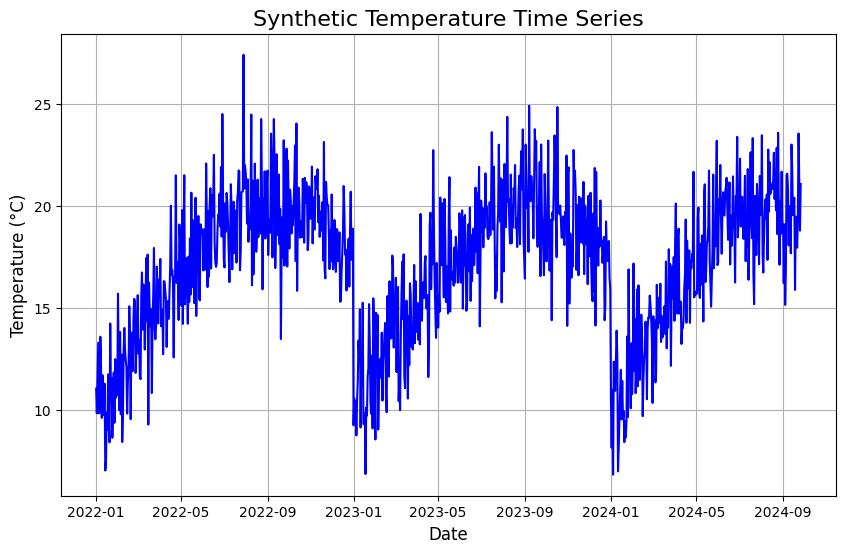

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import seaborn as sns

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# dummy data generation
np.random.seed(42)
dates = pd.date_range(start="2022-01-01", periods=1000, freq="D")
temperature = 10 + 10 * np.sin(2 * np.pi * dates.dayofyear / 1000) + np.random.normal(0, 2, 1000)

data = pd.DataFrame({"Date": dates, "Temperature": temperature})

# Plot the synthetic temperature time series
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x="Date", y="Temperature", color="blue")
plt.title("Synthetic Temperature Time Series", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.grid()
plt.show()


class WeatherDataset(Dataset):
    """
    A custom PyTorch Dataset for weather data.
    Args:
        data (list or numpy array): The weather data.
        sequence_length (int, optional): The length of the sequence of data points. Default is 30.
    Attributes:
        data (list or numpy array): The weather data.
        sequence_length (int): The length of the sequence of data points.
    Methods:
        __len__(): Returns the length of the dataset.
        __getitem__(idx): Returns a sequence of data points and the corresponding label as tensors.
    """
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        # The length of the dataset is the total number of data points minus the sequence length
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        # Get the sequence of data points
        x = self.data[idx:idx + self.sequence_length]
        # The label is the next data point after the sequence
        y = self.data[idx + self.sequence_length]
        # Return the sequence and the label as tensors
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

sequence_length = 120
data_values = data["Temperature"].values

# Split data into training and testing sets
train_size = int(len(data_values) * 0.8)
train_data = data_values[:train_size]
test_data = data_values[train_size - sequence_length:]  # Include overlap for sequence generation

# Prepare DataLoader for the training set
train_dataset = WeatherDataset(train_data, sequence_length=sequence_length)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# Prepare DataLoader for the testing set
test_dataset = WeatherDataset(test_data, sequence_length=sequence_length)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Prepare dataset for RF model
X_train = np.array([train_data[i:i + sequence_length] for i in range(len(train_data) - sequence_length)])
y_train = train_data[sequence_length:]

# Prepare testing dataset for RF model
X_test = np.array([test_data[i:i + sequence_length] for i in range(len(test_data) - sequence_length)])
y_test = test_data[sequence_length:]




In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), self.hidden_layer_size).to(x.device)
        c_0 = torch.zeros(num_layers, x.size(0), self.hidden_layer_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out


# Define model parameters
input_size = 1  # Number of features
hidden_size = 50
num_layers = 2
output_size = 1

# Initialize the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

# Define loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 500
for epoch in range(epochs):
    for seq, labels in train_dataloader:
        seq, labels = seq.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(num_layers, seq.size(0), model.hidden_layer_size).to(device),
                             torch.zeros(num_layers, seq.size(0), model.hidden_layer_size).to(device))
        seq = seq.unsqueeze(-1)  # Add feature dimension
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch} loss: {single_loss.item()}')

d:\softwares\Anaconda\envs\yolo\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\softwares\Anaconda\envs\yolo\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 loss: 177.91650390625
Epoch 10 loss: 12.515481948852539
Epoch 20 loss: 10.465351104736328
Epoch 30 loss: 8.65792465209961
Epoch 40 loss: 9.898262977600098
Epoch 50 loss: 14.68798828125
Epoch 60 loss: 7.373539924621582
Epoch 70 loss: 8.508526802062988
Epoch 80 loss: 8.523666381835938
Epoch 90 loss: 8.629890441894531
Epoch 100 loss: 10.96102523803711
Epoch 110 loss: 20.70218276977539
Epoch 120 loss: 8.302303314208984
Epoch 130 loss: 15.83361530303955
Epoch 140 loss: 14.190106391906738
Epoch 150 loss: 10.520513534545898
Epoch 160 loss: 12.593847274780273
Epoch 170 loss: 19.32332992553711
Epoch 180 loss: 10.32522201538086
Epoch 190 loss: 8.255369186401367
Epoch 200 loss: 18.336563110351562
Epoch 210 loss: 7.573497772216797
Epoch 220 loss: 10.129298210144043
Epoch 230 loss: 7.2109222412109375
Epoch 240 loss: 12.574743270874023
Epoch 250 loss: 15.47314453125
Epoch 260 loss: 7.044075965881348
Epoch 270 loss: 11.856877326965332
Epoch 280 loss: 2.5151779651641846
Epoch 290 loss: 11.9783

Test MSE: 7.3657187137568645


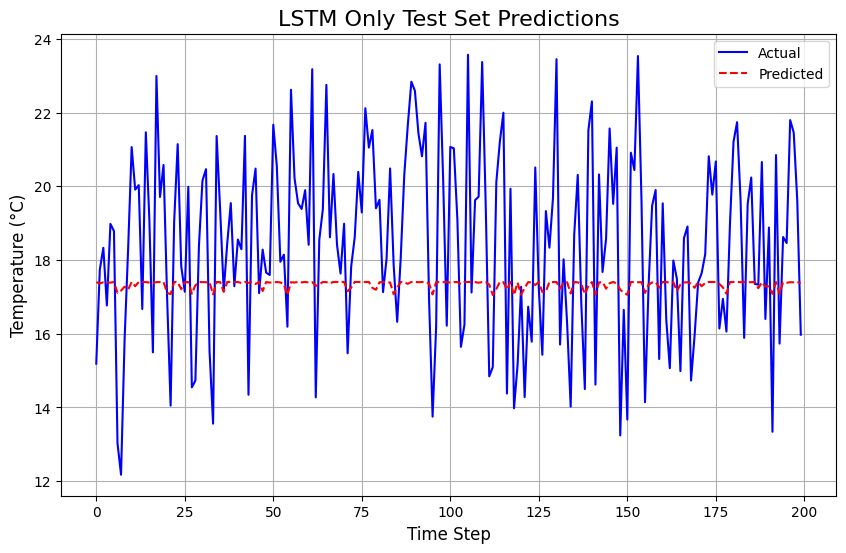

In [18]:
# Testing the model
model.eval()
test_predictions = []
test_labels = []

with torch.no_grad():
    for seq, labels in test_dataloader:
        seq, labels = seq.to(device), labels.to(device) 
        seq = seq.unsqueeze(-1)  # Add feature dimension
        y_pred = model(seq)
        test_predictions.extend(y_pred.squeeze().tolist())
        test_labels.extend(labels.tolist())

# Convert predictions and labels to numpy arrays for easier manipulation
test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)

# Calculate the mean squared error on the test set
test_mse = mean_squared_error(test_labels, test_predictions)
print(f'Test MSE: {test_mse}')

# Visualization of the predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(test_labels, label='Actual', color='blue')
plt.plot(test_predictions, label='Predicted', color='red', linestyle='--')
plt.title('LSTM Only Test Set Predictions', fontsize=16)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend()
plt.grid()
plt.show()

Test MSE: 3.9029109959827455


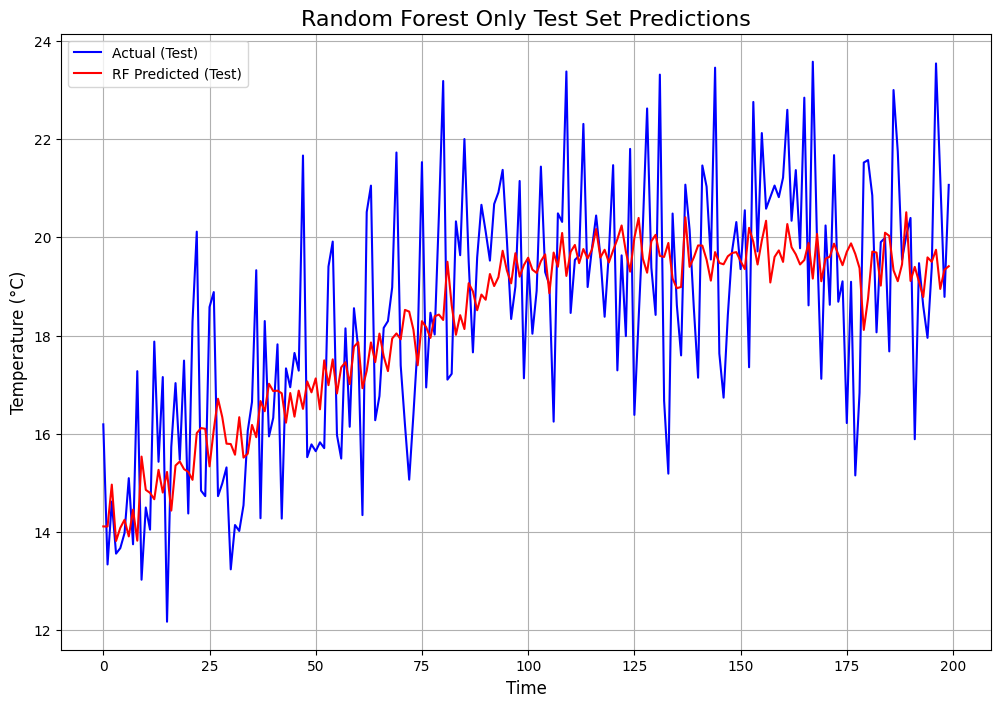

In [19]:

# training random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# training the model with data_value consider the squanence length of 30
rf_model.fit(X_train, y_train)

# RF predictions on the test set
rf_predictions = rf_model.predict(X_test)

# Calculate the mean squared error on the test set
test_mse = mean_squared_error(y_test, rf_predictions)
print(f'Test MSE: {test_mse}')
plt.figure(figsize=(12, 8))
plt.plot(range(len(y_test)), y_test, label="Actual (Test)", color="blue")
plt.plot(range(len(rf_predictions)), rf_predictions, label="RF Predicted (Test)", color="red")
plt.title("Random Forest Only Test Set Predictions", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.legend()
plt.grid()
plt.show()



Test MSE: 13.527909905109537


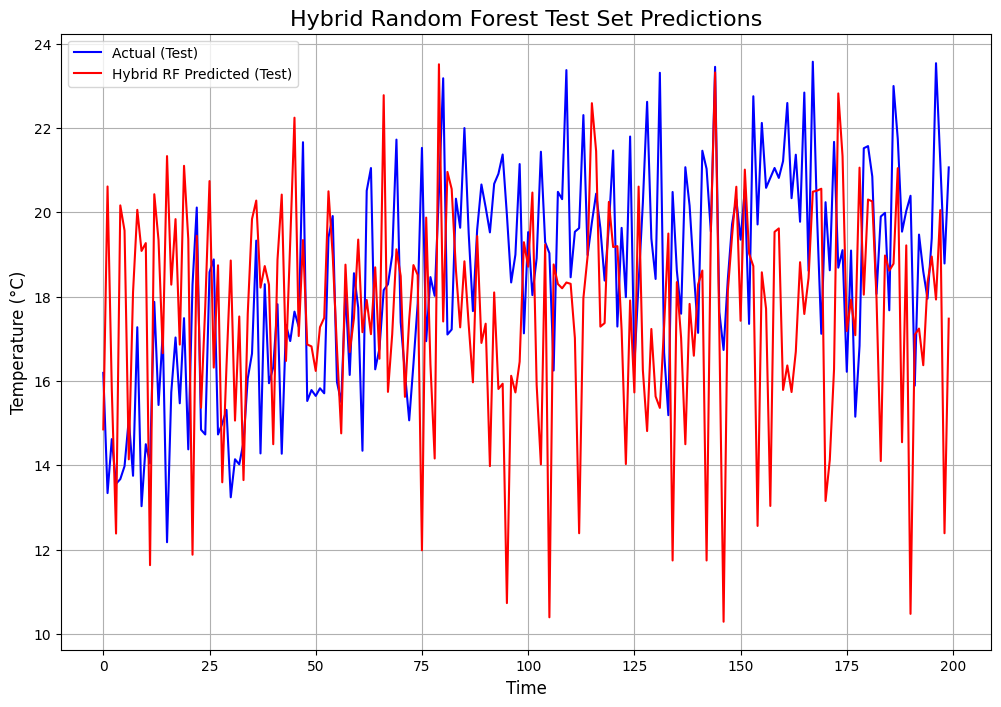

In [20]:
# extract LSTM features from training set and train RF model to predict the temperature
# Extracting LSTM features from the
train_features = []
model.eval()
with torch.no_grad():
    for seq, _ in train_dataloader:
        seq, _ = seq.to(device), _.to(device) 
        seq = seq.unsqueeze(-1)  # Add feature dimension
        features = model(seq)
        train_features.extend(features.tolist())

# Convert the features to a numpy array
train_features = np.array(train_features)

# training random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# training the model with data_value consider the squanence length of 30
rf_model.fit(train_features, y_train)

# extract LSTM features from testing set and predict the temperature
# Extracting LSTM features from the test set
test_features = []
model.eval()
with torch.no_grad():
    for seq, _ in test_dataloader:
        seq, _ = seq.to(device), _.to(device) 
        seq = seq.unsqueeze(-1)  # Add feature dimension
        features = model(seq)
        test_features.extend(features.tolist())
        
# RF predictions on the test set
rf_predictions_hybird = rf_model.predict(test_features)

# Calculate the mean squared error on the test set
test_mse = mean_squared_error(y_test, rf_predictions_hybird)
print(f'Test MSE: {test_mse}')
plt.figure(figsize=(12, 8))
plt.plot(range(len(y_test)), y_test, label="Actual (Test)", color="blue")
plt.plot(range(len(rf_predictions_hybird)), rf_predictions_hybird, label="Hybrid RF Predicted (Test)", color="red")
plt.title("Hybrid Random Forest Test Set Predictions", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.legend()
plt.grid()
plt.show()

